# XGBoost Model predictions for 'Bise' data
<ol><li>Determination of relevant features
<li>Assessment of XGBoost scores on raw and resampled datasets
</ol>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import xgboost as xgb
from xgboost import plot_importance, plot_tree
import pickle
import seaborn as sns; sns.set()
#import pandas_profiling
import datetime as dt
import matplotlib.dates as mdates
import time
import calendar # to convert numbers to months
import os
from os import listdir
from os.path import isfile, join
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc, recall_score,precision_score, accuracy_score, f1_score,precision_recall_curve, average_precision_score
from sklearn import model_selection as ms
import sys
sys.path.append('../04_scripts')
import constants as const
import random as rand
import data_handler as dh
import data_processor as dp
import xgb_handler as xh
import plot_handler as ph

In [30]:
from sklearn.metrics import precision_recall_curve, average_precision_score, auc

In [34]:
pd.set_option('display.max_columns', None)
datapath = '../0_Data/'

## Imbalance in the data relevant for determining 'Bise' with respect to the data which could lead to such classification puts the training in jeopardy
### We take a resampled dataset as reference

### Resampling can be achieved by calling py scripts, as in the following code, which targets the default column 'rule4_episode':

data_classifier = 'bise_classifications_extended.csv.zip'
df_classifier = dh.load_df_from_csv(data_classifier)
df_classifier.rename(columns={'year': 'Year', 'month': 'Month'}, inplace=True)
df_classifier_resampled = dp.resample(df_classifier, 'notebook_resample.csv.zip')

#### Resampling occurs by replacing blocks of negative Bise events with padded blocks of positive Bise events, originating in data from the same season, but from another year
### As sampling occurs with a certain degree of randomness, the achieved ratio of positive and negative is never the same. For further usage we will load a previously saved resampled dataframe

In [3]:
df_classifier_resampled = dh.load_df_from_csv('notebook_resample.csv.zip')
df_classifier_resampled.head()

,datetime,Year,Month,original_index,rule4_episode,bise_event,rule3_episode,rule3_duration,rule4_duration,rule3_label,rule4_label,manual_bise
0,2014-01-01 00:00:00,2014,1,165707.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2014-01-01 00:10:00,2014,1,165708.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2014-01-01 00:20:00,2014,1,165709.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2014-01-01 00:30:00,2014,1,165710.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2014-01-01 00:40:00,2014,1,165711.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
df_classifier_resampled.rule4_episode.value_counts()

0.0    188580
1.0     74221
Name: rule4_episode, dtype: int64

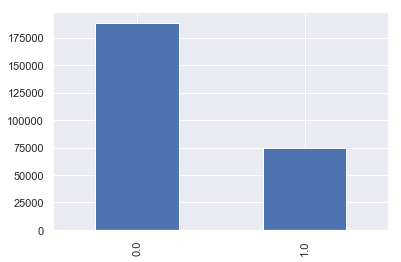

In [5]:
ax = df_classifier_resampled.rule4_episode.value_counts().plot.bar()
#df.plot(x="R-4", y=5, kind="bar", ax=ax, color="C2")
#df.plot(x="X", y="C", kind="bar", ax=ax, color="C3")

plt.show()

In [7]:
df_bise_start_end = dh.load_df_from_csv('bise_classifications_start_end.csv')
df_bise_start_end.rule4_episode.fillna(0).value_counts()

0.0    253698
1.0      9103
Name: rule4_episode, dtype: int64

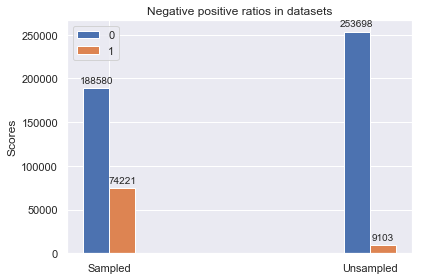

In [8]:
labels = ['Sampled', 'Unsampled']
negatives = [df_classifier_resampled.rule4_episode.value_counts()[0], df_bise_start_end.rule4_episode.fillna(0).value_counts()[0]]
positives = [df_classifier_resampled.rule4_episode.value_counts()[1], df_bise_start_end.rule4_episode.fillna(0).value_counts()[1]]

x = np.arange(len(labels))  # the label locations
width = 0.1  # the width of the bars


fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, negatives, width, label='0')
rects2 = ax.bar(x + width/2, positives, width, label='1')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Scores')
ax.set_title('Negative positive ratios in datasets')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()


def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


autolabel(rects1)
autolabel(rects2)

fig.tight_layout()

plt.show()

In [9]:
print(df_classifier_resampled.rule4_episode[df_classifier_resampled.rule4_episode == 0].count(),  df_classifier_resampled.rule4_episode[df_classifier_resampled.rule4_episode == 1].count())

188580 74221


In [10]:
df_bise_features_for_modelling = dh.load_df_from_csv('bise_features_for_modelling.csv')
df_bise_features_for_modelling.head()

,datetime,KLO_Wind_dir_filled,KLO_Wind_dir_filled_1d,KLO_Wind_speed_filled,KLO_Wind_max_filled,KLO_Hum_imputed,KLO_QNH_imputed,KLO_Air_temp_imputed,KLO_Hum_imputed_1d,KLO_QNH_imputed_1d,KLO_Air_temp_imputed_1d,REH_Wind_dir_filled,REH_Wind_dir_filled_1d,REH_Wind_speed_filled,REH_Wind_max_filled,REH_Hum_imputed,REH_QNH_imputed,REH_Air_temp_imputed,REH_Hum_imputed_1d,REH_QNH_imputed_1d,REH_Air_temp_imputed_1d,SMA_Wind_dir_filled,SMA_Wind_dir_filled_1d,SMA_Wind_speed_filled,SMA_Wind_max_filled,SMA_Hum_imputed,SMA_QNH_imputed,SMA_Air_temp_imputed,SMA_Hum_imputed_1d,SMA_QNH_imputed_1d,SMA_Air_temp_imputed_1d,TAE_Wind_dir_filled,TAE_Wind_dir_filled_1d,TAE_Wind_speed_filled,TAE_Wind_max_filled,TAE_Hum_imputed,TAE_QNH_filled,TAE_Air_temp_imputed,TAE_Hum_imputed_1d,TAE_QNH_filled_1d,TAE_Air_temp_imputed_1d,WAE_Wind_dir_filled,WAE_Wind_dir_filled_1d,WAE_Wind_speed_filled,WAE_Wind_max_filled,WAE_Hum_imputed,WAE_QNH_filled,WAE_Air_temp_imputed,WAE_Hum_imputed_1d,WAE_QNH_filled_1d,WAE_Air_temp_imputed_1d,MUB_Wind_dir_imputed,MUB_Wind_dir_imputed_1d,MUB_Wind_max_imputed,MUB_Hum_imputed,MUB_QNH_imputed,MUB_Air_temp_imputed,MUB_Hum_imputed_1d,MUB_QNH_imputed_1d,MUB_Air_temp_imputed_1d,PAY_Wind_dir_imputed,PAY_Wind_dir_imputed_1d,PAY_Wind_max_imputed,PAY_Hum_imputed,PAY_QNH_imputed,PAY_Air_temp_imputed,PAY_Hum_imputed_1d,PAY_QNH_imputed_1d,PAY_Air_temp_imputed_1d,PUY_Wind_dir_imputed,PUY_Wind_dir_imputed_1d,PUY_Wind_max_imputed,PUY_Hum_imputed,PUY_QNH_imputed,PUY_Air_temp_imputed,PUY_Hum_imputed_1d,PUY_QNH_imputed_1d,PUY_Air_temp_imputed_1d,GVE_Wind_dir_imputed,GVE_Wind_dir_imputed_1d,GVE_Wind_max_imputed,GVE_Hum_imputed,GVE_QNH_imputed,GVE_Air_temp_imputed,GVE_Hum_imputed_1d,GVE_QNH_imputed_1d,GVE_Air_temp_imputed_1d,GUT_Wind_dir_imputed,GUT_Wind_dir_imputed_1d,GUT_Wind_max_imputed,GUT_Hum_imputed,GUT_QNH_imputed,GUT_Air_temp_imputed,GUT_Hum_imputed_1d,GUT_QNH_imputed_1d,GUT_Air_temp_imputed_1d,ARH_Wind_dir_imputed,ARH_Wind_dir_imputed_1d,ARH_Wind_max_imputed,ARH_Hum_imputed,ARH_QNH_imputed,ARH_Air_temp_imputed,ARH_Hum_imputed_1d,ARH_QNH_imputed_1d,ARH_Air_temp_imputed_1d,BIZ_Wind_dir_imputed,BIZ_Wind_dir_imputed_1d,BIZ_Wind_max_imputed,BIZ_Hum_imputed,BIZ_QNH_imputed,BIZ_Air_temp_imputed,BIZ_Hum_imputed_1d,BIZ_QNH_imputed_1d,BIZ_Air_temp_imputed_1d,SHA_Wind_dir_imputed,SHA_Wind_dir_imputed_1d,SHA_Wind_max_imputed,SHA_Hum_imputed,SHA_QNH_imputed,SHA_Air_temp_imputed,SHA_Hum_imputed_1d,SHA_QNH_imputed_1d,SHA_Air_temp_imputed_1d,MOA_Wind_dir_imputed,MOA_Wind_dir_imputed_1d,MOA_Wind_max_imputed,MOA_Hum_imputed,MOA_QNH_imputed,MOA_Air_temp_imputed,MOA_Hum_imputed_1d,MOA_QNH_imputed_1d,MOA_Air_temp_imputed_1d,KOP_Wind_dir_imputed,KOP_Wind_dir_imputed_1d,KOP_Wind_max_imputed,KOP_Hum_imputed,KOP_QNH_imputed,KOP_Air_temp_imputed,KOP_Hum_imputed_1d,KOP_QNH_imputed_1d,KOP_Air_temp_imputed_1d,WYN_Wind_dir_imputed,WYN_Wind_dir_imputed_1d,WYN_Wind_max_imputed,WYN_Hum_imputed,WYN_QNH_imputed,WYN_Air_temp_imputed,WYN_Hum_imputed_1d,WYN_QNH_imputed_1d,WYN_Air_temp_imputed_1d,BUS_Wind_dir_imputed,BUS_Wind_dir_imputed_1d,BUS_Wind_max_imputed,BUS_Hum_imputed,BUS_QNH_imputed,BUS_Air_temp_imputed,BUS_Hum_imputed_1d,BUS_QNH_imputed_1d,BUS_Air_temp_imputed_1d,KLO_QNH_imputed_minus_REH_QNH_imputed_1d,KLO_QNH_imputed_minus_SMA_QNH_imputed_1d,KLO_QNH_imputed_minus_TAE_QNH_imputed_1d,KLO_QNH_imputed_minus_WAE_QNH_imputed_1d,KLO_QNH_imputed_minus_ARH_QNH_imputed_1d,KLO_QNH_imputed_minus_BIZ_QNH_imputed_1d,KLO_QNH_imputed_minus_BUS_QNH_imputed_1d,KLO_QNH_imputed_minus_GUT_QNH_imputed_1d,KLO_QNH_imputed_minus_GVE_QNH_imputed_1d,KLO_QNH_imputed_minus_KOP_QNH_imputed_1d,KLO_QNH_imputed_minus_MOA_QNH_imputed_1d,KLO_QNH_imputed_minus_MUB_QNH_imputed_1d,KLO_QNH_imputed_minus_PAY_QNH_imputed_1d,KLO_QNH_imputed_minus_PUY_QNH_imputed_1d,KLO_QNH_imputed_minus_SHA_QNH_imputed_1d,KLO_QNH_imputed_minus_WYN_QNH_imputed_1d,KLO_QNH_imputed_minus_REH_QNH_imputed,KLO_QNH_imputed_minus_SMA_QNH_imputed,KLO_QNH_imputed_minus_TAE_QNH_imputed,KLO_QNH_imputed_minus_WAE_QNH_imputed,KLO_QNH_impute

In [11]:
df_sampled_merge = df_classifier_resampled.drop(columns=['Month']).join(df_bise_start_end[['rule3_start', 'rule3_end', 'rule4_start', 'rule4_end', 'manual_bise_start', 'manual_bise_end']], on='original_index')

In [12]:
df_bise_start_end.columns

Index(['datetime', 'rule3_episode', 'rule4_episode', 'rule3_duration',
       'rule4_duration', 'rule3_label', 'rule4_label', 'rule3_start',
       'rule3_end', 'rule4_start', 'rule4_end', 'manual_bise',
       'manual_bise_start', 'manual_bise_end'],
      dtype='object')

In [13]:
df_sampled_merge.columns

Index(['datetime', 'Year', 'original_index', 'rule4_episode', 'bise_event',
       'rule3_episode', 'rule3_duration', 'rule4_duration', 'rule3_label',
       'rule4_label', 'manual_bise', 'rule3_start', 'rule3_end', 'rule4_start',
       'rule4_end', 'manual_bise_start', 'manual_bise_end'],
      dtype='object')

In [14]:
df_sampled_merge = df_sampled_merge.join(df_bise_features_for_modelling.drop(columns=['datetime', 'Hour', 'Month', 'manual_bise']), on='original_index')

In [15]:
df_sampled_merge.columns.tolist()

['datetime',
 'Year',
 'original_index',
 'rule4_episode',
 'bise_event',
 'rule3_episode',
 'rule3_duration',
 'rule4_duration',
 'rule3_label',
 'rule4_label',
 'manual_bise',
 'rule3_start',
 'rule3_end',
 'rule4_start',
 'rule4_end',
 'manual_bise_start',
 'manual_bise_end',
 'KLO_Wind_dir_filled',
 'KLO_Wind_dir_filled_1d',
 'KLO_Wind_speed_filled',
 'KLO_Wind_max_filled',
 'KLO_Hum_imputed',
 'KLO_QNH_imputed',
 'KLO_Air_temp_imputed',
 'KLO_Hum_imputed_1d',
 'KLO_QNH_imputed_1d',
 'KLO_Air_temp_imputed_1d',
 'REH_Wind_dir_filled',
 'REH_Wind_dir_filled_1d',
 'REH_Wind_speed_filled',
 'REH_Wind_max_filled',
 'REH_Hum_imputed',
 'REH_QNH_imputed',
 'REH_Air_temp_imputed',
 'REH_Hum_imputed_1d',
 'REH_QNH_imputed_1d',
 'REH_Air_temp_imputed_1d',
 'SMA_Wind_dir_filled',
 'SMA_Wind_dir_filled_1d',
 'SMA_Wind_speed_filled',
 'SMA_Wind_max_filled',
 'SMA_Hum_imputed',
 'SMA_QNH_imputed',
 'SMA_Air_temp_imputed',
 'SMA_Hum_imputed_1d',
 'SMA_QNH_imputed_1d',
 'SMA_Air_temp_imputed_1d',


In [16]:
print(df_sampled_merge.rule4_episode[df_sampled_merge.rule4_episode == 0].count(),  df_sampled_merge.rule4_episode[df_sampled_merge.rule4_episode == 1].count())

188580 74221


In [17]:
df_sampled_merge.shape

(262801, 465)

## Check for NaNs,...none

In [18]:
df_sampled_merge.isna().sum()[df_sampled_merge.isna().sum() > 0]

rule3_end          1
rule4_end          1
manual_bise_end    1
dtype: int64

## Focus on beginning of 'Bise' event

Text(0.5, 1.0, 'Wind directions in Kloten')

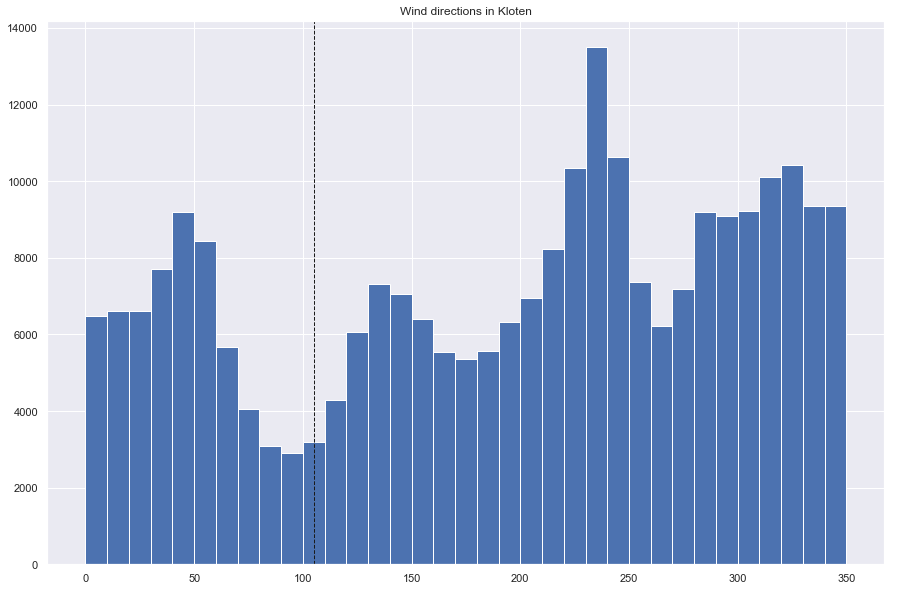

In [19]:
plt.figure(figsize=(15,10))
plt.hist(x=df_bise_features_for_modelling.KLO_Wind_dir_filled, bins=range(0,360,10))
plt.axvline(105, color='k', linestyle='dashed', linewidth=1)
plt.title('Wind directions in Kloten')

df_klo_start_full = get_station_features(df_merged_for_modelling, 'KLO', ['rule4_start', 'rule3_start', 'Year'])
print(df_klo_start_full.shape)
df_klo_start_full.head()

In [20]:
df_klo_start_full = dp.get_station_features(df_sampled_merge, 'KLO', ['Year', 'rule3_episode', 'rule3_start','rule4_episode', 'rule4_start','manual_bise', 'manual_bise_start','bise_event'])
print(df_klo_start_full.shape)
df_klo_start_full.head()

(262801, 51)


,datetime,Year,rule3_episode,rule3_start,rule4_episode,rule4_start,manual_bise,manual_bise_start,bise_event,KLO_Wind_dir_filled,KLO_Wind_dir_filled_1d,KLO_Wind_speed_filled,KLO_Wind_max_filled,KLO_Hum_imputed,KLO_QNH_imputed,KLO_Air_temp_imputed,KLO_Hum_imputed_1d,KLO_QNH_imputed_1d,KLO_Air_temp_imputed_1d,KLO_QNH_imputed_minus_REH_QNH_imputed_1d,KLO_QNH_imputed_minus_SMA_QNH_imputed_1d,KLO_QNH_imputed_minus_TAE_QNH_imputed_1d,KLO_QNH_imputed_minus_WAE_QNH_imputed_1d,KLO_QNH_imputed_minus_ARH_QNH_imputed_1d,KLO_QNH_imputed_minus_BIZ_QNH_imputed_1d,KLO_QNH_imputed_minus_BUS_QNH_imputed_1d,KLO_QNH_imputed_minus_GUT_QNH_imputed_1d,KLO_QNH_imputed_minus_GVE_QNH_imputed_1d,KLO_QNH_imputed_minus_KOP_QNH_imputed_1d,KLO_QNH_imputed_minus_MOA_QNH_imputed_1d,KLO_QNH_imputed_minus_MUB_QNH_imputed_1d,KLO_QNH_imputed_minus_PAY_QNH_imputed_1d,KLO_QNH_imputed_minus_PUY_QNH_imputed_1d,KLO_QNH_imputed_minus_SHA_QNH_imputed_1d,KLO_QNH_imputed_minus_WYN_QNH_imputed_1d,KLO_QNH_imputed_minus_REH_QNH_imputed,KLO_QNH_imputed_minus_SMA_QNH_imputed,KLO_QNH_imputed_minus_TAE_QNH_imputed,KLO_QNH_imputed_minus_WAE_QNH_imputed,KLO_QNH_imputed_minus_ARH_QNH_imputed,KLO_QNH_imputed_minus_BIZ_QNH_imputed,KLO_QNH_imputed_minus_BUS_QNH_imputed,KLO_QNH_imputed_minus_GUT_QNH_imputed,KLO_QNH_imputed_minus_GVE_QNH_imputed,KLO_QNH_imputed_minus_KOP_QNH_imputed,KLO_QNH_imputed_minus_MOA_QNH_imputed,KLO_QNH_imputed_minus_MUB_QNH_imputed,KLO_QNH_imputed_minus_PAY_QNH_imputed,KLO_QNH_imputed_minus_PUY_QNH_imputed,KLO_QNH_imputed_minus_SHA_QNH_imputed,KLO_QNH_imputed_minus_WYN_QNH_imputed
0,2014-01-01 00:00:00,2014,0.0,0,0.0,0,0.0,0,0.0,12,-345.0,4.2,5.9,79.9,1017.4,3.2,4.0,0.2,-0.3,-1.136870e-13,-0.1,0.1,-1.000000e-01,-1.000000e-01,0.1,-1.136870e-13,-0.1,-1.136870e-13,-1.000000e-01,-1.136870e-13,0.000000e+00,-1.136870e-13,0.000000e+00,1.000000e-01,-1.136870e-13,0.2,0.5,0.6,0.6,-0.1,0.0,-0.1,0.1,0.2,0.2,0.2,0.6,0.2,0.6,0.3,0.3
1,2014-01-01 00:10:00,2014,0.0,0,0.0,0,0.0,0,0.0,3,-9.0,3.1,4.3,83.6,1017.5,2.9,3.7,0.1,-0.3,-1.000000e-01,0.0,0.0,-1.000000e-01,-1.000000e-01,0.1,-1.000000e-01,0.0,-1.000000e-01,1.136870e-13,-1.000000e-01,-2.000000e-01,-3.000000e-01,-1.000000e-01,-1.000000e-01,-1.000000e-01,0.1,0.5,0.6,0.5,-0.2,0.1,-0.2,0.1,0.1,0.2,0.1,0.4,-0.1,0.5,0.2,0.2
2,2014-01-01 00:20:00,2014,0.0,0,0.0,0,0.0,0,0.0,341,338.0,2.0,3.2,85.3,1017.6,2.6,1.7,0.1,-0.3,-1.000000e-01,-0.1,-0.2,-2.000000e-01,1.136870e-13,-0.2,-1.000000e-01,-0.1,-1.000000e-01,-1.000000e-01,-2.000000e-01,-1.000000e-01,0.000000e+00,-2.000000e-01,-1.000000e-01,-1.000000e-01,0.0,0.4,0.4,0.3,-0.2,-0.1,-0.3,0.0,0.0,0.1,-0.1,0.3,-0.1,0.3,0.1,0.1
3,2014-01-01 00:30:00,2014,0.0,0,0.0,0,0.0,0,0.0,297,-44.0,1.6,2.2,86.2,1017.8,2.3,0.9,0.2,-0.3,1.000000e-01,0.0,-0.4,-1.000000e-01,-1.136870e-13,0.0,-1.000000e-01,-0.1,0.000000e+00,1.000000e-01,0.000000e+00,-1.136870e-13,0.000000e+00,-1.136870e-13,-1.136870e-13,-1.000000e-01,0.1,0.4,0.0,0.2,-0.2,-0.1,-0.4,-0.1,0.0,0.2,-0.1,0.3,-0.1,0.3,0.1,0.0
4,2014-01-01 00:40:00,2014,0.0,0,0.0,0,0.0,0,0.0,294,-3.0,1.3,2.0,86.5,1018.0,2.2,0.3,0.2,-0.1,1.136870e-13,0.0,0.0,1.136870e-13,0.000000e+00,-0.2,-1.000000e-01,0.0,0.000000e+00,-1.000000e-01,0.000000e+00,1.000000e-01,2.000000e-01,0.000000e+00,-1.000000e-01,0.000000e+00,0.1,0.4,0.0,0.2,-0.2,-0.3,-0.5,-0.1,0.0,0.1,-0.1,0.4,0.1,0.3,0.0,0.0


In [21]:
df_klo_start_full.columns

Index(['datetime', 'Year', 'rule3_episode', 'rule3_start', 'rule4_episode',
       'rule4_start', 'manual_bise', 'manual_bise_start', 'bise_event',
       'KLO_Wind_dir_filled', 'KLO_Wind_dir_filled_1d',
       'KLO_Wind_speed_filled', 'KLO_Wind_max_filled', 'KLO_Hum_imputed',
       'KLO_QNH_imputed', 'KLO_Air_temp_imputed', 'KLO_Hum_imputed_1d',
       'KLO_QNH_imputed_1d', 'KLO_Air_temp_imputed_1d',
       'KLO_QNH_imputed_minus_REH_QNH_imputed_1d',
       'KLO_QNH_imputed_minus_SMA_QNH_imputed_1d',
       'KLO_QNH_imputed_minus_TAE_QNH_imputed_1d',
       'KLO_QNH_imputed_minus_WAE_QNH_imputed_1d',
       'KLO_QNH_imputed_minus_ARH_QNH_imputed_1d',
       'KLO_QNH_imputed_minus_BIZ_QNH_imputed_1d',
       'KLO_QNH_imputed_minus_BUS_QNH_imputed_1d',
       'KLO_QNH_imputed_minus_GUT_QNH_imputed_1d',
       'KLO_QNH_imputed_minus_GVE_QNH_imputed_1d',
       'KLO_QNH_imputed_minus_KOP_QNH_imputed_1d',
       'KLO_QNH_imputed_minus_MOA_QNH_imputed_1d',
       'KLO_QNH_imputed_minus_MUB

In [22]:
selected_kloten_cols = [c for c in df_klo_start_full.columns if not c.endswith('_1d')]
selected_kloten_cols

['datetime',
 'Year',
 'rule3_episode',
 'rule3_start',
 'rule4_episode',
 'rule4_start',
 'manual_bise',
 'manual_bise_start',
 'bise_event',
 'KLO_Wind_dir_filled',
 'KLO_Wind_speed_filled',
 'KLO_Wind_max_filled',
 'KLO_Hum_imputed',
 'KLO_QNH_imputed',
 'KLO_Air_temp_imputed',
 'KLO_QNH_imputed_minus_REH_QNH_imputed',
 'KLO_QNH_imputed_minus_SMA_QNH_imputed',
 'KLO_QNH_imputed_minus_TAE_QNH_imputed',
 'KLO_QNH_imputed_minus_WAE_QNH_imputed',
 'KLO_QNH_imputed_minus_ARH_QNH_imputed',
 'KLO_QNH_imputed_minus_BIZ_QNH_imputed',
 'KLO_QNH_imputed_minus_BUS_QNH_imputed',
 'KLO_QNH_imputed_minus_GUT_QNH_imputed',
 'KLO_QNH_imputed_minus_GVE_QNH_imputed',
 'KLO_QNH_imputed_minus_KOP_QNH_imputed',
 'KLO_QNH_imputed_minus_MOA_QNH_imputed',
 'KLO_QNH_imputed_minus_MUB_QNH_imputed',
 'KLO_QNH_imputed_minus_PAY_QNH_imputed',
 'KLO_QNH_imputed_minus_PUY_QNH_imputed',
 'KLO_QNH_imputed_minus_SHA_QNH_imputed',
 'KLO_QNH_imputed_minus_WYN_QNH_imputed']

### First attempts were done with this limited set of features, but produced poor results

train_features_klo = ['KLO_Wind_dir_filled', 
       'KLO_Wind_speed_filled', 'KLO_Wind_max_filled', 'KLO_Hum_imputed',
       'KLO_QNH_imputed', 'KLO_Air_temp_imputed']



In [23]:
df_klo_start_selected = df_klo_start_full[selected_kloten_cols]
df_klo_start_selected.head()

,datetime,Year,rule3_episode,rule3_start,rule4_episode,rule4_start,manual_bise,manual_bise_start,bise_event,KLO_Wind_dir_filled,KLO_Wind_speed_filled,KLO_Wind_max_filled,KLO_Hum_imputed,KLO_QNH_imputed,KLO_Air_temp_imputed,KLO_QNH_imputed_minus_REH_QNH_imputed,KLO_QNH_imputed_minus_SMA_QNH_imputed,KLO_QNH_imputed_minus_TAE_QNH_imputed,KLO_QNH_imputed_minus_WAE_QNH_imputed,KLO_QNH_imputed_minus_ARH_QNH_imputed,KLO_QNH_imputed_minus_BIZ_QNH_imputed,KLO_QNH_imputed_minus_BUS_QNH_imputed,KLO_QNH_imputed_minus_GUT_QNH_imputed,KLO_QNH_imputed_minus_GVE_QNH_imputed,KLO_QNH_imputed_minus_KOP_QNH_imputed,KLO_QNH_imputed_minus_MOA_QNH_imputed,KLO_QNH_imputed_minus_MUB_QNH_imputed,KLO_QNH_imputed_minus_PAY_QNH_imputed,KLO_QNH_imputed_minus_PUY_QNH_imputed,KLO_QNH_imputed_minus_SHA_QNH_imputed,KLO_QNH_imputed_minus_WYN_QNH_imputed
0,2014-01-01 00:00:00,2014,0.0,0,0.0,0,0.0,0,0.0,12,4.2,5.9,79.9,1017.4,3.2,0.2,0.5,0.6,0.6,-0.1,0.0,-0.1,0.1,0.2,0.2,0.2,0.6,0.2,0.6,0.3,0.3
1,2014-01-01 00:10:00,2014,0.0,0,0.0,0,0.0,0,0.0,3,3.1,4.3,83.6,1017.5,2.9,0.1,0.5,0.6,0.5,-0.2,0.1,-0.2,0.1,0.1,0.2,0.1,0.4,-0.1,0.5,0.2,0.2
2,2014-01-01 00:20:00,2014,0.0,0,0.0,0,0.0,0,0.0,341,2.0,3.2,85.3,1017.6,2.6,0.0,0.4,0.4,0.3,-0.2,-0.1,-0.3,0.0,0.0,0.1,-0.1,0.3,-0.1,0.3,0.1,0.1
3,2014-01-01 00:30:00,2014,0.0,0,0.0,0,0.0,0,0.0,297,1.6,2.2,86.2,1017.8,2.3,0.1,0.4,0.0,0.2,-0.2,-0.1,-0.4,-0.1,0.0,0.2,-0.1,0.3,-0.1,0.3,0.1,0.0
4,2014-01-01 00:40:00,2014,0.0,0,0.0,0,0.0,0,0.0,294,1.3,2.0,86.5,1018.0,2.2,0.1,0.4,0.0,0.2,-0.2,-0.3,-0.5,-0.1,0.0,0.1,-0.1,0.4,0.1,0.3,0.0,0.0


In [24]:
df_klo_start_selected.isna().sum()[df_klo_start_selected.isna().sum() > 0]

Series([], dtype: int64)

### No NaNs, so proceed to splitting

In [25]:
df_train_klo = df_klo_start_selected[df_klo_start_selected['Year']<2018]#.drop(columns=['datetime', 'rule4_start', 'rule3_start', 'Year'])
df_test_klo = df_klo_start_selected[df_klo_start_selected['Year']==2018]  #.drop(columns=['rule4_start', 'rule3_start','Year'])
print(df_train_klo.shape, df_test_klo.shape)

(210384, 31) (52417, 31)


df_train_klo = df_train_master[train_cols_klo]
df_test_klo = df_test_master[train_cols_klo]
reg = xgb.XGBClassifier(n_estimators=1000)

In [26]:
df_train_klo.head()

,datetime,Year,rule3_episode,rule3_start,rule4_episode,rule4_start,manual_bise,manual_bise_start,bise_event,KLO_Wind_dir_filled,KLO_Wind_speed_filled,KLO_Wind_max_filled,KLO_Hum_imputed,KLO_QNH_imputed,KLO_Air_temp_imputed,KLO_QNH_imputed_minus_REH_QNH_imputed,KLO_QNH_imputed_minus_SMA_QNH_imputed,KLO_QNH_imputed_minus_TAE_QNH_imputed,KLO_QNH_imputed_minus_WAE_QNH_imputed,KLO_QNH_imputed_minus_ARH_QNH_imputed,KLO_QNH_imputed_minus_BIZ_QNH_imputed,KLO_QNH_imputed_minus_BUS_QNH_imputed,KLO_QNH_imputed_minus_GUT_QNH_imputed,KLO_QNH_imputed_minus_GVE_QNH_imputed,KLO_QNH_imputed_minus_KOP_QNH_imputed,KLO_QNH_imputed_minus_MOA_QNH_imputed,KLO_QNH_imputed_minus_MUB_QNH_imputed,KLO_QNH_imputed_minus_PAY_QNH_imputed,KLO_QNH_imputed_minus_PUY_QNH_imputed,KLO_QNH_imputed_minus_SHA_QNH_imputed,KLO_QNH_imputed_minus_WYN_QNH_imputed
0,2014-01-01 00:00:00,2014,0.0,0,0.0,0,0.0,0,0.0,12,4.2,5.9,79.9,1017.4,3.2,0.2,0.5,0.6,0.6,-0.1,0.0,-0.1,0.1,0.2,0.2,0.2,0.6,0.2,0.6,0.3,0.3
1,2014-01-01 00:10:00,2014,0.0,0,0.0,0,0.0,0,0.0,3,3.1,4.3,83.6,1017.5,2.9,0.1,0.5,0.6,0.5,-0.2,0.1,-0.2,0.1,0.1,0.2,0.1,0.4,-0.1,0.5,0.2,0.2
2,2014-01-01 00:20:00,2014,0.0,0,0.0,0,0.0,0,0.0,341,2.0,3.2,85.3,1017.6,2.6,0.0,0.4,0.4,0.3,-0.2,-0.1,-0.3,0.0,0.0,0.1,-0.1,0.3,-0.1,0.3,0.1,0.1
3,2014-01-01 00:30:00,2014,0.0,0,0.0,0,0.0,0,0.0,297,1.6,2.2,86.2,1017.8,2.3,0.1,0.4,0.0,0.2,-0.2,-0.1,-0.4,-0.1,0.0,0.2,-0.1,0.3,-0.1,0.3,0.1,0.0
4,2014-01-01 00:40:00,2014,0.0,0,0.0,0,0.0,0,0.0,294,1.3,2.0,86.5,1018.0,2.2,0.1,0.4,0.0,0.2,-0.2,-0.3,-0.5,-0.1,0.0,0.1,-0.1,0.4,0.1,0.3,0.0,0.0


For common cases such as ads clickthrough log, the dataset is extremely imbalanced. This can affect the training of XGBoost model, and there are two ways to improve it.

If you care only about the overall performance metric (AUC) of your prediction

Balance the positive and negative weights via scale_pos_weight

Use AUC for evaluation

## Following models were run on sampled datasets¶

### Target 'rule4_start' without  event anticipation

In [27]:
df_train_x = df_train_klo.drop(columns=['datetime', 'Year', 'rule3_episode', 'rule3_start', 'rule4_episode','rule4_start', 'manual_bise', 'manual_bise_start', 'bise_event'])
df_train_y = df_train_klo['rule4_start']
df_test_x = df_test_klo.drop(columns=['datetime', 'Year', 'rule3_episode', 'rule3_start', 'rule4_episode','rule4_start', 'manual_bise', 'manual_bise_start', 'bise_event',])
df_test_y = df_test_klo['rule4_start']

weight_param = df_train_y.value_counts()[0] / df_train_y.value_counts()[1]
hyperparams = {'scale_pos_weight': weight_param, 'n_estimators':1000, "eval_metric": "auc"}

xgboostmodels_r4_1, xgboostscores_r4_1, cm_r4_1, pred_r4_1 = xh.run_xgboost_predictions_no_tuning(df_train_x, df_train_y, df_test_x, df_test_y,const.steps_1_hour, '../03_serializations', **hyperparams)

precision score: 0.297367
recall score: 0.980085
f1 score: 0.456291
              precision    recall  f1-score   support

           0       1.00      0.97      0.98     51713
           1       0.30      0.98      0.46       703

   micro avg       0.97      0.97      0.97     52416
   macro avg       0.65      0.97      0.72     52416
weighted avg       0.99      0.97      0.98     52416

1 0.9800853485064012
Model improved accuracy, saving to ../03_serializations/xgb_no_tuning_1563480883.970787.dat
precision score: 0.265490
recall score: 0.963016
f1 score: 0.416231
              precision    recall  f1-score   support

           0       1.00      0.96      0.98     51712
           1       0.27      0.96      0.42       703

   micro avg       0.96      0.96      0.96     52415
   macro avg       0.63      0.96      0.70     52415
weighted avg       0.99      0.96      0.97     52415

2 0.9630156472261735
precision score: 0.277414
recall score: 0.964438
f1 score: 0.430887
        

In [28]:
df_train_x = df_train_klo.drop(columns=['datetime', 'Year', 'rule3_episode', 'rule3_start', 'rule4_episode','rule4_start', 'manual_bise', 'manual_bise_start', 'bise_event'])
df_train_y = df_train_klo['rule4_episode']
df_test_x = df_test_klo.drop(columns=['datetime', 'Year', 'rule3_episode', 'rule3_start', 'rule4_episode','rule4_start', 'manual_bise', 'manual_bise_start', 'bise_event',])
df_test_y = df_test_klo['rule4_episode']

weight_param = df_train_y.value_counts()[0] / df_train_y.value_counts()[1]
hyperparams = {'scale_pos_weight': weight_param, 'n_estimators':1000, "eval_metric": "auc"}

xgboostmodels_r4, xgboostscores_r4, cm_r4, pred_r4 = xh.run_xgboost_predictions_no_tuning(df_train_x, df_train_y, df_test_x, df_test_y,1 , '../03_serializations', **hyperparams)

precision score: 0.917233
recall score: 0.971603
f1 score: 0.943636
              precision    recall  f1-score   support

         0.0       0.99      0.96      0.97     35900
         1.0       0.92      0.97      0.94     16516

   micro avg       0.96      0.96      0.96     52416
   macro avg       0.95      0.97      0.96     52416
weighted avg       0.96      0.96      0.96     52416

1 0.9716032937757326
Model improved accuracy, saving to ../03_serializations/xgb_no_tuning_1563482609.033211.dat


In [29]:
cm_r4

{'xgboost_model_10': array([[34452,  1448],
        [  469, 16047]])}

### This re-run was meant for testing improvements on script 'xgboost_handler'

In [31]:
df_train_x = df_train_klo.drop(columns=['datetime', 'Year', 'rule3_episode', 'rule3_start', 'rule4_episode','rule4_start', 'manual_bise', 'manual_bise_start', 'bise_event'])
df_train_y = df_train_klo['rule4_episode']
df_test_x = df_test_klo.drop(columns=['datetime', 'Year', 'rule3_episode', 'rule3_start', 'rule4_episode','rule4_start', 'manual_bise', 'manual_bise_start', 'bise_event',])
df_test_y = df_test_klo['rule4_episode']

weight_param = df_train_y.value_counts()[0] / df_train_y.value_counts()[1]
print('-/+ ratio:', weight_param)
hyperparams = {'scale_pos_weight': weight_param, 'n_estimators':1000, "eval_metric": "auc"}

# never give a variable the same name as a module (e.g. confusion_matrix)
reg, rec_score, confusion_matrix, y_pred = xh.run_xgboost_prediction(df_train_x, df_train_y, df_test_x, df_test_y,const.steps_2_hours, '../03_serializations', **hyperparams)

-/+ ratio: 2.645853912139329
precision score: 0.799968
recall score: 0.907302
f1 score: 0.850261
              precision    recall  f1-score   support

         0.0       0.95      0.90      0.92     35889
         1.0       0.80      0.91      0.85     16516

   micro avg       0.90      0.90      0.90     52405
   macro avg       0.88      0.90      0.89     52405
weighted avg       0.91      0.90      0.90     52405

saving to ../03_serializations/xgb_no_tuning_single_pred1563482900.334646.dat


In [32]:
confusion_matrix

(array([[32142,  3747],
        [ 1531, 14985]]), array([1., 0., 0., ..., 0., 0., 0.]))

In [34]:
prec_score, rec_score, f_score = xh.get_scores(df_test_y[:-const.steps_2_hours], y_pred)

precision score: 0.683109
recall score: 0.774764
f1 score: 0.726055


In [38]:
# get false and true positive rates
fpr, tpr, thresholds = roc_curve(df_test_y[:-const.steps_2_hours].values, y_pred, pos_label=1)

In [39]:
# get area under the curve
roc_auc = auc(fpr, tpr)

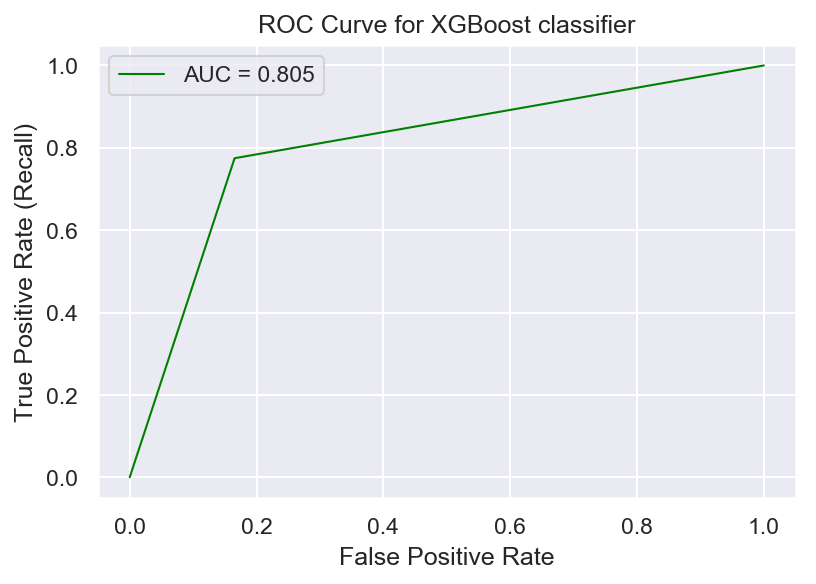

In [40]:
# PLOT ROC curve
plt.figure(dpi=150)
plt.plot(fpr, tpr, lw=1, color='green', label=f'AUC = {roc_auc:.3f}')
plt.title('ROC Curve for XGBoost classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Recall)')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.legend()
plt.show()

In [41]:
thresholds

array([2., 1., 0.])

In [42]:
df_train_x = df_train_klo.drop(columns=['datetime', 'rule4_start', 'rule3_start', 'Year'])
df_train_y = df_train_klo['rule4_start']
df_train_y = xh.anticipate_start(df_train_y, const.steps_1_hour)
df_test_x = df_test_klo.drop(columns=['datetime', 'rule4_start', 'rule3_start', 'Year'])
df_test_y = df_test_klo['rule4_start']

weight_param = df_train_y.value_counts()[0] / df_train_y.value_counts()[1]
hyperparams = {'scale_pos_weight': weight_param, 'n_estimators':1000, "eval_metric": "auc"}

xgboostmodels_r4_biased, xgboostscores_r4_biased, cm_r4_biased, pred_r4_biased = xh.run_xgboost_predictions_no_tuning(df_train_x, df_train_y, df_test_x, df_test_y,const.steps_2_hours, '../03_serializations', **hyperparams)

precision score: 0.067866
recall score: 0.735420
f1 score: 0.124264
              precision    recall  f1-score   support

           0       1.00      0.86      0.92     51713
           1       0.07      0.74      0.12       703

   micro avg       0.86      0.86      0.86     52416
   macro avg       0.53      0.80      0.52     52416
weighted avg       0.98      0.86      0.91     52416

1 0.7354196301564723
Model improved accuracy, saving to ../03_serializations/xgb_no_tuning_1563491835.9279292.dat
precision score: 0.055451
recall score: 0.631579
f1 score: 0.101952
              precision    recall  f1-score   support

           0       0.99      0.85      0.92     51712
           1       0.06      0.63      0.10       703

   micro avg       0.85      0.85      0.85     52415
   macro avg       0.52      0.74      0.51     52415
weighted avg       0.98      0.85      0.91     52415

2 0.631578947368421
precision score: 0.051783
recall score: 0.625889
f1 score: 0.095652
        

## Poor results testing the unsampled dataset
### This outcome not expected and has no obvious explanation. 
#### The resources need to be verified, random slices of the sampled data will be selected and compared with the original dataset
1. Retrieve original modlling dataset
2. Retrieve stored sampled classification dataset
3. Merge original dataset from 1. above on original index of 2.
4. Pick slices from events and non-events and check

In [2]:
df_bise_features_for_modelling = dh.load_df_from_csv('bise_features_for_modelling.csv.zip')
df_bise_features_for_modelling.head()

,datetime,KLO_Wind_dir_filled,KLO_Wind_dir_filled_1d,KLO_Wind_speed_filled,KLO_Wind_max_filled,KLO_Hum_imputed,KLO_QNH_imputed,KLO_Air_temp_imputed,KLO_Hum_imputed_1d,KLO_QNH_imputed_1d,...,WYN_QNH_imputed_minus_MOA_QNH_imputed,WYN_QNH_imputed_minus_MUB_QNH_imputed,WYN_QNH_imputed_minus_PAY_QNH_imputed,WYN_QNH_imputed_minus_PUY_QNH_imputed,WYN_QNH_imputed_minus_SHA_QNH_imputed,Hour,Month,rule4_episode_1_0,rule4_duration_with_0,manual_bise
0,2014-01-01 00:00:00,138,NaN,3.9,5.6,96.1,1016.6,-3.0,NaN,NaN,...,0.2,0.3,0.3,-0.8,0.8,0,1,0,0,0
1,2014-01-01 00:10:00,149,11.0,3.3,5.7,95.2,1016.7,-3.0,-0.9,0.1,...,0.1,-0.1,0.0,-1.1,0.5,0,1,0,0,0
2,2014-01-01 00:20:00,145,-4.0,3.1,4.4,94.4,1016.7,-3.0,-0.8,0.0,...,0.1,-0.2,0.1,-1.1,0.5,0,1,0,0,0
3,2014-01-01 00:30:00,127,-18.0,3.7,4.6,91.7,1016.7,-2.9,-2.7,0.0,...,0.3,-0.1,0.3,-0.9,0.6,0,1,0,0,0
4,2014-01-01 00:40:00,131,4.0,4.1,5.0,90.8,1016.6,-2.8,-0.9,-0.1,...,0.3,-0.2,0.2,-1.0,0.6,0,1,0,0,0


In [3]:
df_classifier_resampled = dh.load_df_from_csv('notebook_resample.csv.zip')
df_classifier_resampled.head()

,datetime,Year,Month,original_index,rule4_episode,bise_event,rule3_episode,rule3_duration,rule4_duration,rule3_label,rule4_label,manual_bise
0,2014-01-01 00:00:00,2014,1,165707.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2014-01-01 00:10:00,2014,1,165708.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2014-01-01 00:20:00,2014,1,165709.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2014-01-01 00:30:00,2014,1,165710.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2014-01-01 00:40:00,2014,1,165711.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
df_classifier_resampled.rename(columns={'Year': 'year', 'Month': 'month'}, inplace=True)
df_classifier_resampled.columns

Index(['datetime', 'year', 'month', 'original_index', 'rule4_episode',
       'bise_event', 'rule3_episode', 'rule3_duration', 'rule4_duration',
       'rule3_label', 'rule4_label', 'manual_bise'],
      dtype='object')

In [5]:
df_bise_start_end = dh.load_df_from_csv('bise_classifications_start_end.csv')
df_bise_start_end.isna().sum()

datetime                  0
rule3_episode             0
rule4_episode             0
rule3_duration       253090
rule4_duration       253698
rule3_label          253090
rule4_label          253698
rule3_start               0
rule3_end                 1
rule4_start               0
rule4_end                 1
manual_bise               0
manual_bise_start         0
manual_bise_end           1
dtype: int64

In [6]:
df_bise_start_end.fillna(0, inplace=True)
df_bise_start_end.isna().sum()

datetime             0
rule3_episode        0
rule4_episode        0
rule3_duration       0
rule4_duration       0
rule3_label          0
rule4_label          0
rule3_start          0
rule3_end            0
rule4_start          0
rule4_end            0
manual_bise          0
manual_bise_start    0
manual_bise_end      0
dtype: int64

In [7]:
df_bise_start_end.head()

,datetime,rule3_episode,rule4_episode,rule3_duration,rule4_duration,rule3_label,rule4_label,rule3_start,rule3_end,rule4_start,rule4_end,manual_bise,manual_bise_start,manual_bise_end
0,2014-01-01 00:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0,0.0,0,0,0.0
1,2014-01-01 00:10:00,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0,0.0,0,0,0.0
2,2014-01-01 00:20:00,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0,0.0,0,0,0.0
3,2014-01-01 00:30:00,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0,0.0,0,0,0.0
4,2014-01-01 00:40:00,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0,0.0,0,0,0.0


In [8]:
df_original = df_bise_start_end.join(df_bise_features_for_modelling.drop(columns=['datetime', 'manual_bise']))
df_original.shape

(262801, 464)

In [9]:
df_classifier_resampled = df_classifier_resampled.drop(columns=['rule4_episode','rule3_episode', 'rule3_duration', 'rule4_duration','rule3_label', 'rule4_label', 'manual_bise'])
df_classifier_resampled = df_classifier_resampled.join(df_bise_start_end.drop(columns=['datetime']), on='original_index')

In [10]:
df_classifier_resampled.head()

,datetime,year,month,original_index,bise_event,rule3_episode,rule4_episode,rule3_duration,rule4_duration,rule3_label,rule4_label,rule3_start,rule3_end,rule4_start,rule4_end,manual_bise,manual_bise_start,manual_bise_end
0,2014-01-01 00:00:00,2014,1,165707.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0,0.0,0,0,0.0
1,2014-01-01 00:10:00,2014,1,165708.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0,0.0,0,0,0.0
2,2014-01-01 00:20:00,2014,1,165709.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0,0.0,0,0,0.0
3,2014-01-01 00:30:00,2014,1,165710.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0,0.0,0,0,0.0
4,2014-01-01 00:40:00,2014,1,165711.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0,0.0,0,0,0.0


In [11]:
df_classifier_resampled = df_classifier_resampled.join(df_bise_features_for_modelling.drop(columns=['datetime', 'Hour', 'Month', 'manual_bise']), on='original_index')

In [12]:
df_classifier_resampled.head()

,datetime,year,month,original_index,bise_event,rule3_episode,rule4_episode,rule3_duration,rule4_duration,rule3_label,...,WYN_QNH_imputed_minus_GUT_QNH_imputed,WYN_QNH_imputed_minus_GVE_QNH_imputed,WYN_QNH_imputed_minus_KOP_QNH_imputed,WYN_QNH_imputed_minus_MOA_QNH_imputed,WYN_QNH_imputed_minus_MUB_QNH_imputed,WYN_QNH_imputed_minus_PAY_QNH_imputed,WYN_QNH_imputed_minus_PUY_QNH_imputed,WYN_QNH_imputed_minus_SHA_QNH_imputed,rule4_episode_1_0,rule4_duration_with_0
0,2014-01-01 00:00:00,2014,1,165707.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.2,-0.1,-0.1,-0.1,0.3,-0.1,0.3,0.0,0,0
1,2014-01-01 00:10:00,2014,1,165708.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.1,-0.1,0.0,-0.1,0.2,-0.3,0.3,0.0,0,0
2,2014-01-01 00:20:00,2014,1,165709.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.1,-0.1,0.0,-0.2,0.2,-0.2,0.2,0.0,0,0
3,2014-01-01 00:30:00,2014,1,165710.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.1,0.0,0.2,-0.1,0.3,-0.1,0.3,0.1,0,0
4,2014-01-01 00:40:00,2014,1,165711.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.1,0.0,0.1,-0.1,0.4,0.1,0.3,0.0,0,0


### Check the features
1. Pick sample columns
2. Collect the events on sampled data
3. Collect non-events on original data


In [25]:
cols_for_check = ['rule3_episode','rule4_episode','KLO_Wind_dir_filled','KLO_Wind_dir_filled_1d','KLO_Wind_speed_filled','KLO_Wind_max_filled','KLO_Hum_imputed',
'KLO_QNH_imputed','KLO_Air_temp_imputed','KLO_Hum_imputed_1d','KLO_QNH_imputed_1d','KLO_Air_temp_imputed_1d',
'REH_Wind_dir_filled','REH_Wind_dir_filled_1d','REH_Wind_speed_filled','REH_Wind_max_filled',
'REH_Hum_imputed','REH_QNH_imputed','REH_Air_temp_imputed','REH_Hum_imputed_1d','REH_QNH_imputed_1d',
'REH_Air_temp_imputed_1d']

In [14]:
df_classifier_resampled['rule3_episode'].value_counts()

0.0    187722
1.0     75079
Name: rule3_episode, dtype: int64

In [15]:
df_classifier_resampled['rule4_episode'].value_counts()

0.0    188580
1.0     74221
Name: rule4_episode, dtype: int64

In [16]:
df_classifier_resampled['bise_event'].value_counts()

1.0    136367
0.0    126434
Name: bise_event, dtype: int64

In [17]:
event_indexes = df_classifier_resampled.index[df_classifier_resampled['bise_event'] == 1.0].tolist()
event_indexes += df_classifier_resampled.index[df_classifier_resampled['rule3_episode'] == 1.0].tolist()
event_indexes += df_classifier_resampled.index[df_classifier_resampled['rule4_episode'] == 1.0].tolist()
event_index = np.unique(event_indexes)
event_index.sort()

In [26]:
def check_col_vals(df_samp, df_orig, cols, i1, i2):
    df_res = pd.DataFrame(columns=(['original_index'] + cols))
    samples = df_samp.loc[i1:i2][cols]
    orig_indexes = samples[:][0:1].values
    i = i1
    for ind in orig_indexes:
        if i > i2:
            print('Block sizes inconsistent')
            return
        row1 = [ind] + df_orig[cols].iloc[ind]
        row2 = [ind] + df_samp[cols].iloc[i]
        for c in cols:
            if row1[cols] != row2[cols]:
                print('Inconsistency', c, ind, i, row1[cols], row2[cols])
        i +=1
    vals = samples.iloc[:][1:len(cols)].values
    print(df_samp[cols].head())
    print(df_orig[cols].head())
    print(i1, i2, samples.shape, type(samples), type(orig_indexes), vals.shape)
    return df_res

In [27]:
ind1 = 0
ind2 = 0
for i in event_indexes:
    if i > ind2:
        if i - const.steps_2_hours > 0:
            ind1 = i - const.steps_2_hours
        ind2 = i + const.steps_2_hours
        if i + const.steps_2_hours >= len(df_classifier_resampled):
            ind2 = len(df_classifier_resampled)
        
        df_verifications = check_col_vals(df_classifier_resampled, df_original, cols_for_check, ind1, ind2)

ValueError: Unable to coerce to Series, length must be 22: given 1

In [ ]:
df_feat_check_res = 

In [37]:
cols_for_check

['KLO_Wind_dir_filled',
 'KLO_Wind_dir_filled_1d',
 'KLO_Wind_speed_filled',
 'KLO_Wind_max_filled',
 'KLO_Hum_imputed',
 'KLO_QNH_imputed',
 'KLO_Air_temp_imputed',
 'KLO_Hum_imputed_1d',
 'KLO_QNH_imputed_1d',
 'KLO_Air_temp_imputed_1d',
 'REH_Wind_dir_filled',
 'REH_Wind_dir_filled_1d',
 'REH_Wind_speed_filled',
 'REH_Wind_max_filled',
 'REH_Hum_imputed',
 'REH_QNH_imputed',
 'REH_Air_temp_imputed',
 'REH_Hum_imputed_1d',
 'REH_QNH_imputed_1d',
 'REH_Air_temp_imputed_1d']

In [43]:
# train
from sklearn.ensemble import RandomForestClassifier

df_train_x = df_train_klo.drop(columns=['datetime', 'Year', 'rule3_episode', 'rule3_start', 'rule4_episode','rule4_start', 'manual_bise', 'manual_bise_start', 'bise_event'])
df_train_y = df_train_klo['rule4_episode']
df_test_x = df_test_klo.drop(columns=['datetime', 'Year', 'rule3_episode', 'rule3_start', 'rule4_episode','rule4_start', 'manual_bise', 'manual_bise_start', 'bise_event',])
df_test_y = df_test_klo['rule4_episode']


rf_clf = RandomForestClassifier(n_estimators=100)
rf_clf.fit(df_train_x[:-const.steps_2_hours], df_train_y[const.steps_2_hours:])

# get the probability distribution
probas = rf_clf.predict_proba(df_test_x[:-const.steps_2_hours])

In [44]:
probas

array([[9.80000000e-01, 2.00000000e-02],
       [9.90000000e-01, 1.00000000e-02],
       [9.99444444e-01, 5.55555556e-04],
       ...,
       [9.26388889e-01, 7.36111111e-02],
       [9.44904762e-01, 5.50952381e-02],
       [9.90000000e-01, 1.00000000e-02]])

In [45]:
df_train_x = df_train_klo.drop(columns=['datetime', 'Year', 'rule3_episode', 'rule3_start', 'rule4_episode','rule4_start', 'manual_bise', 'manual_bise_start', 'bise_event'])
df_train_y = df_train_klo['rule4_episode']
df_test_x = df_test_klo.drop(columns=['datetime', 'Year', 'rule3_episode', 'rule3_start', 'rule4_episode','rule4_start', 'manual_bise', 'manual_bise_start', 'bise_event',])
df_test_y = df_test_klo['rule4_episode']

rf_clf1 = RandomForestClassifier(n_estimators=100)
rf_clf1.fit(df_train_x[:-const.steps_2_hours], df_train_y[const.steps_2_hours:])

# get the probability distribution
probas1 = rf_clf1.predict_proba(df_test_x[const.steps_2_hours:])

# get the predictions
predicts1 = rf_clf1.predict(df_test_x[const.steps_2_hours:])

In [55]:
predicts1

array([0., 0., 0., ..., 0., 0., 0.])

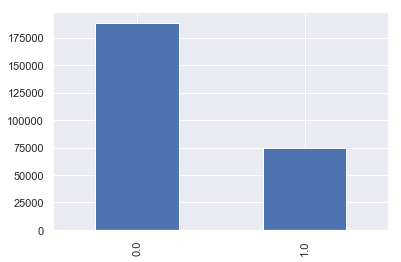

In [46]:
df_sampled_merge['rule4_episode'].value_counts().plot.bar()

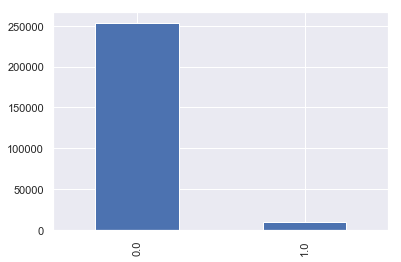

In [47]:
df_bise_start_end['rule4_episode'].fillna(0).value_counts().plot.bar()

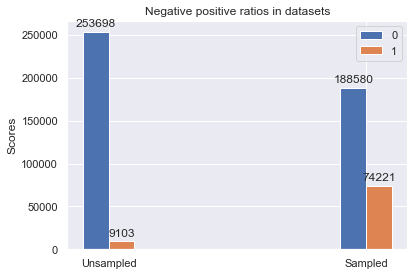

In [57]:
ph.plot_binary_distribution(df_bise_start_end['rule4_episode'].fillna(0), df_sampled_merge['rule4_episode'])

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, precision_recall_curve, auc, roc_auc_score, roc_curve, recall_score, classification_report

parameters = {
    'C': np.linspace(1, 10, 10)
             }
lr = LogisticRegression()
clf = GridSearchCV(lr, parameters, cv=5, verbose=5, n_jobs=3)
clf.fit(X_train_res, y_train_res.ravel())